#### 라이브러리 설치

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# from IPython.display import clear_output 
# clear_output()

In [1]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# loading
from tqdm import tqdm

# progress bar in repeated code

import pandas as pd
import numpy as np

# Feature Selection
from sklearn.feature_selection import RFECV

# preprocessing
from sklearn.preprocessing import LabelEncoder

# Impute
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
# plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from psynlig import plot_correlation_heatmap
import seaborn as sns
import missingno as msno

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold

# Scoring
from sklearn.metrics import f1_score

# Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor, ExtraTreesClassifier, ExtraTreesRegressor
import lightgbm
import xgboost
import catboost

In [2]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

### 데이터 불러오기

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [5]:
### Label Encoding
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    
    for label in np.unique(test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i]) 
print('Done.')

Done.


In [6]:
train

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TRAIN_0000,1,0.531957,4,2,2.0,95.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,TRAIN_0001,1,0.531105,5,2,2.0,96.0,0.0,45.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,TRAIN_0002,1,0.532292,5,2,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,1,0.528141,5,2,2.0,87.0,0.0,45.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,TRAIN_0004,1,0.532289,5,2,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,TRAIN_1127,0,0.516681,2,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,TRAIN_1128,1,0.530413,4,2,2.0,102.0,0.0,45.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,TRAIN_1129,1,0.533311,5,2,1.0,88.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,TRAIN_1130,0,0.513135,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test

,PRODUCT_ID,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TEST_000,4,2,2.0,94.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,5,2,3.0,89.0,0.0,45.0,10.0,0.0,51.0,...,0.000007,0.000004,0.189134,0.000032,0.000664,0.000041,0.000004,0.000003,0.187,0.000030
2,TEST_002,4,2,2.0,100.0,0.0,45.0,10.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,5,2,2.0,91.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,5,2,2.0,87.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,TEST_530,5,2,1.0,95.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,TEST_531,5,2,2.0,91.0,0.0,45.0,10.0,0.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
532,TEST_532,4,2,2.0,93.0,0.0,45.0,10.0,0.0,45.0,...,0.000007,0.000005,0.190519,0.000009,0.001260,0.000024,0.000004,0.000002,0.190,0.000005
533,TEST_533,5,2,2.0,93.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Y_Class & Y_Quality

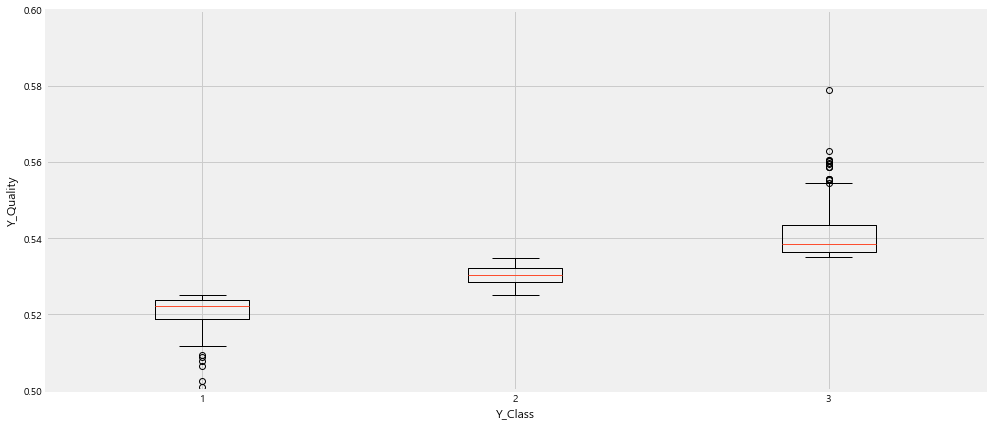

In [8]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [9]:
train.Y_Class.value_counts().sort_index()

0    165
1    766
2    201
Name: Y_Class, dtype: int64

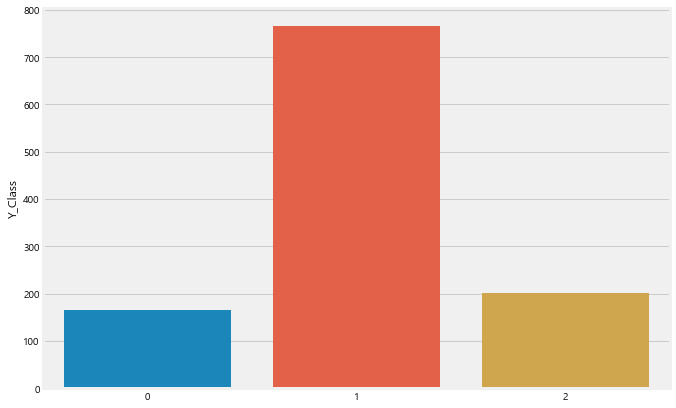

1    766
2    201
0    165
Name: Y_Class, dtype: int64

In [10]:
# class 별 갯수
rcParams['figure.figsize'] = 10, 7
sns.barplot(x=[0, 1, 2], y=train.Y_Class.value_counts().sort_index(), ci="sd")
plt.show()
train.Y_Class.value_counts()

### nunique <= 1인 변수 삭제

In [11]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외 (학습이 의미없기 때문)
def remove_col(train_df):
    for x in train_df.columns[5:]:
        if train_df[x].nunique()<=1: # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
    return train_df

train = remove_col(train)

In [12]:
# Timestamp 제거 및 Y 분리
train_x, train_y = train.drop(columns=['Y_Class', 'PRODUCT_ID', 'Y_Quality']), train['Y_Class']
test = test[train_x.columns]

In [13]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,4,2,2.0,95.0,45.0,10.0,45.0,10.0,31.0,483.4,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,5,2,2.0,96.0,45.0,10.0,53.0,10.0,52.0,519.3,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,5,2,2.0,95.0,45.0,10.0,60.0,10.0,52.0,502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2,2.0,87.0,45.0,10.0,53.0,10.0,52.0,478.9,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,5,2,2.0,95.0,45.0,10.0,51.0,10.0,52.0,508.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 결측치 확인

<AxesSubplot:>

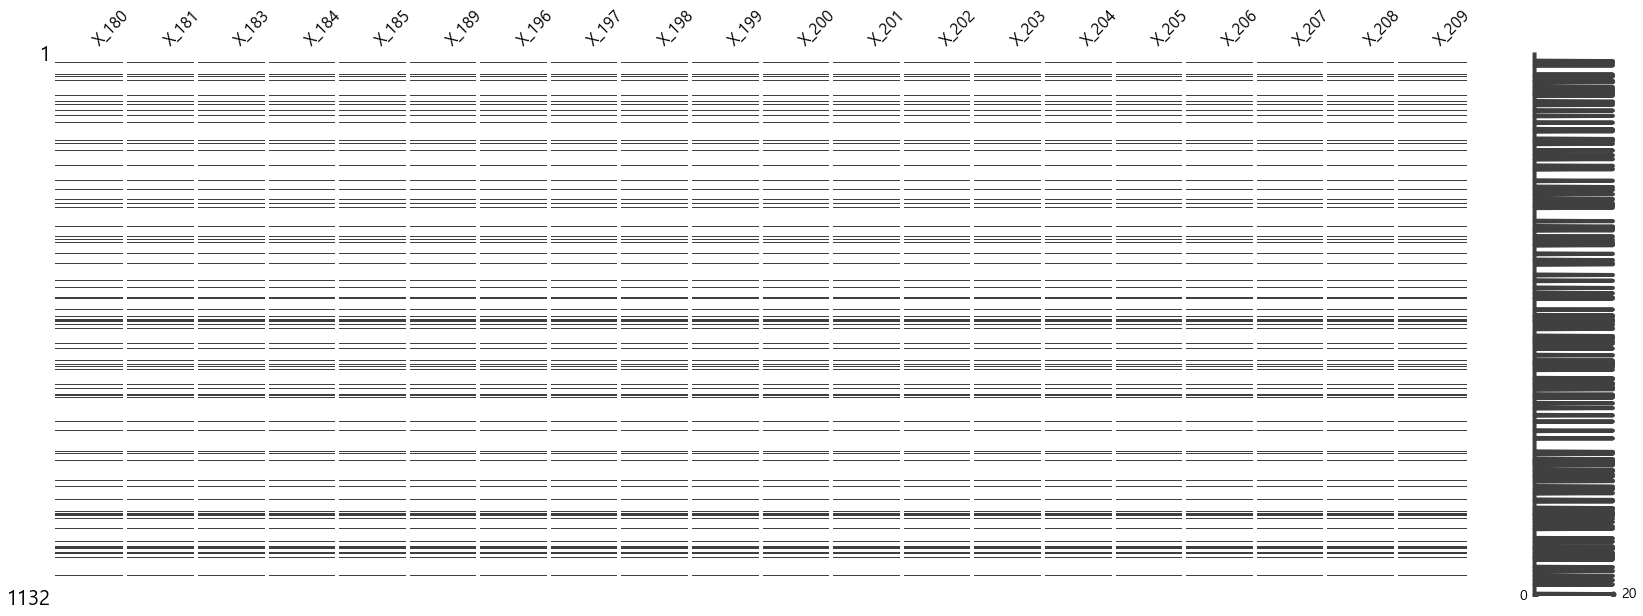

In [14]:
# 20개의 열만 뽑아 확인해 보았는데도 결측치가 굉장히 많다.
msno.matrix(train_x[train_x.columns[130:150]])

### 상관관계 확인
* 히트맵은 대칭을 이루고 있음. 각 변수끼리 상관관계를 표시할 수 있는 경우가 명확하게 분류 됨.

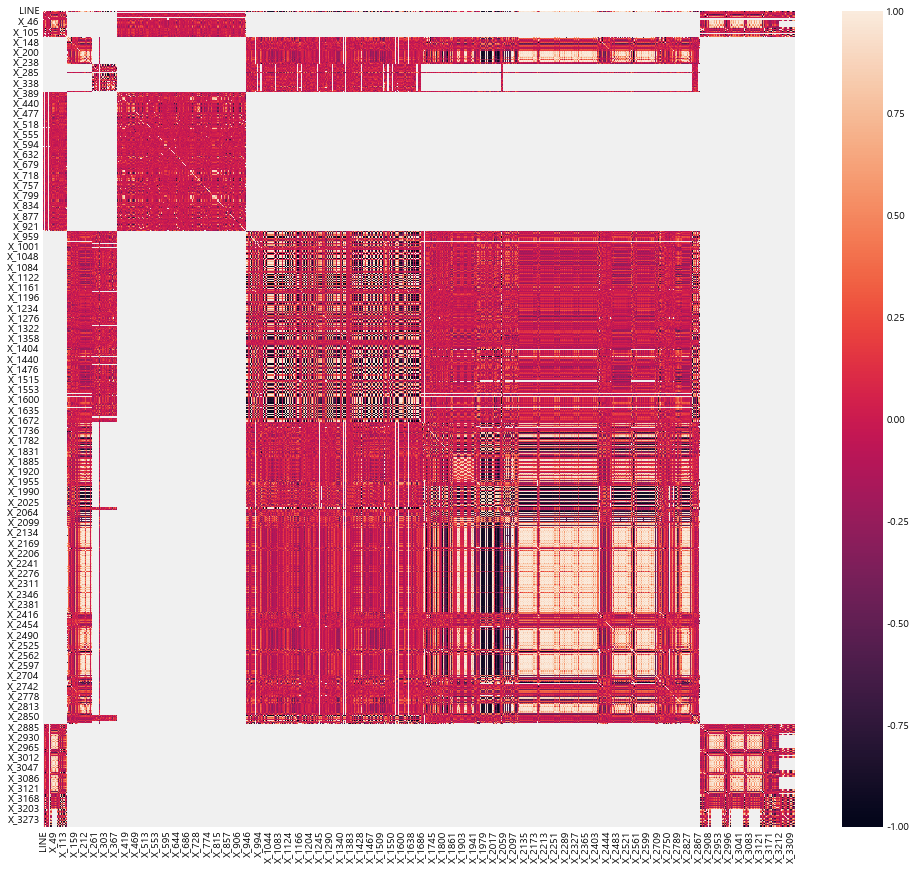

In [15]:
rcParams['figure.figsize'] = 15, 15
sns.heatmap(train_x.corr())
plt.show()

### LINE, PRODUCT_CODE 별 데이터 분포

In [16]:
print('LINE, PRODUCT_CODE', end='\n\n')
for c in train_x.PRODUCT_CODE.unique():
    for l in train_x.LINE.unique():
        if len(train_x[(train_x["LINE"]==l) & (train_x["PRODUCT_CODE"]==c)]):
            print(f'{l}, {c}, {len(train_x[(train_x["LINE"]==l) & (train_x["PRODUCT_CODE"]==c)])}')

LINE, PRODUCT_CODE

4, 2, 400
5, 2, 430
0, 0, 66
3, 0, 66
2, 0, 86
1, 0, 76
4, 1, 4
5, 1, 4


* LINE과 PRODUCT_CODE의 분포를 확인해보면

PRODUCT_CODE=2 -> LINE = 4, 5

PRODUCT_CODE=0 -> LINE = 0, 1, 2, 3

PRODUCT_CODE=1 -> LINE = 4, 5

#### PRODUCT_CODE = (0, 1, 2) 에 대한 변수들의 상관관계

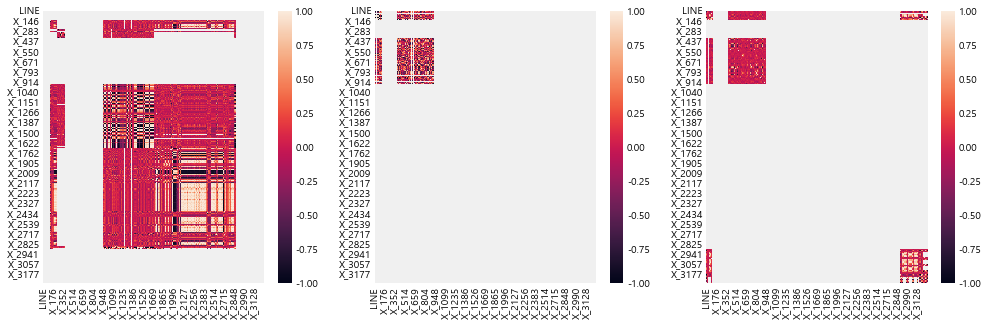

In [17]:
rcParams['figure.figsize'] = 15, 5

fig, ax = plt.subplots(ncols=3)
for i in range(3):
    sns.heatmap(train_x[train_x['PRODUCT_CODE']==i].corr(), ax=ax[i])
plt.show()

* PRODUCT_CODE = 1 인 경우는 PRODUCT_CODE=2 인 경우와 변수가 많이 겹친다.
* PRODUCT_CODE = 1 은 표본이 8개 밖에 안되므로 PRODUCT_CODE=2 와 병합한다.

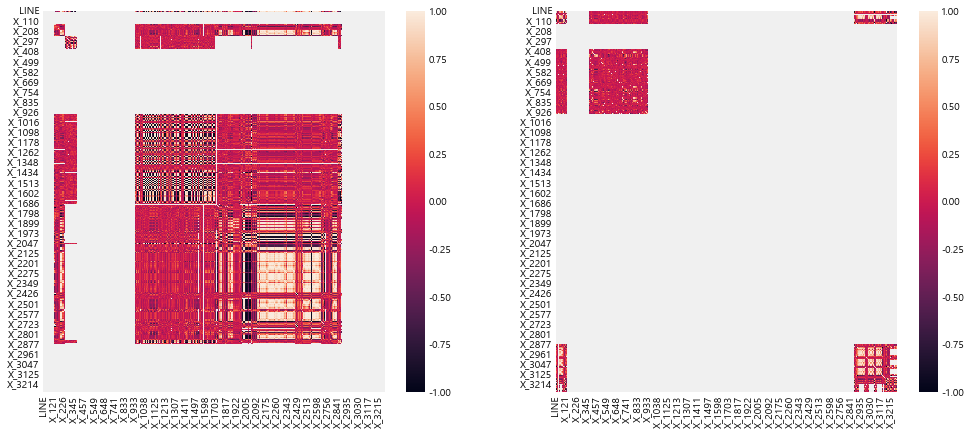

In [18]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots(ncols=2)
sns.heatmap(train_x[train_x['PRODUCT_CODE']==0].corr(), ax=ax[0])
sns.heatmap(train_x[train_x['PRODUCT_CODE']!=0].corr(), ax=ax[1])
plt.show()

### 데이터 슬라이싱

In [19]:
train_x0 = train_x[train_x['PRODUCT_CODE']==0]
train_x1 = train_x[train_x['PRODUCT_CODE']!=0]
train_y0 = train_y.iloc[train_x0.index]
train_y1 = train_y.iloc[train_x1.index]
test0 = test[test['PRODUCT_CODE']==0]
test1 = test[test['PRODUCT_CODE']!=0]

train_x0.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
17,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train_x1.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,4,2,2.0,95.0,45.0,10.0,45.0,10.0,31.0,483.4,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,5,2,2.0,96.0,45.0,10.0,53.0,10.0,52.0,519.3,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,5,2,2.0,95.0,45.0,10.0,60.0,10.0,52.0,502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2,2.0,87.0,45.0,10.0,53.0,10.0,52.0,478.9,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,5,2,2.0,95.0,45.0,10.0,51.0,10.0,52.0,508.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### nunique <= 1 인 변수들 제거

In [43]:
train_x0 = remove_col(train_x0)
train_x1 = remove_col(train_x1)
test0 = test0[train_x0.columns]
test1 = test1[train_x1.columns]

train_x0.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_128,X_129,X_130,X_131,X_132,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
17,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,3,0,NaN,NaN,NaN,NaN,NaN,20153.0,24984.0,0.21,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
21,2,0,NaN,NaN,NaN,18031.0,18031.0,NaN,NaN,0.19,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
22,2,0,NaN,NaN,NaN,8164.0,8164.0,NaN,NaN,0.19,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
27,3,0,NaN,NaN,NaN,NaN,NaN,17014.0,21844.0,0.20,...,50.45,50.29,57.54,52.59,62.37,0.0,NaN,NaN,NaN,NaN


In [44]:
train_x1.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,4,2,2.0,95.0,45.0,10.0,45.0,10.0,31.0,483.4,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189000,0.000006
1,5,2,2.0,96.0,45.0,10.0,53.0,10.0,52.0,519.3,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185000,0.000029
2,5,2,2.0,95.0,45.0,10.0,60.0,10.0,52.0,502.5,...,0.000007,0.000003,0.189552,0.000032,0.000689,0.000039,0.000003,0.000003,0.187667,0.000030
3,5,2,2.0,87.0,45.0,10.0,53.0,10.0,52.0,478.9,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188000,0.000031
4,5,2,2.0,95.0,45.0,10.0,51.0,10.0,52.0,508.4,...,0.000007,0.000003,0.190205,0.000031,0.000669,0.000039,0.000003,0.000003,0.186667,0.000029


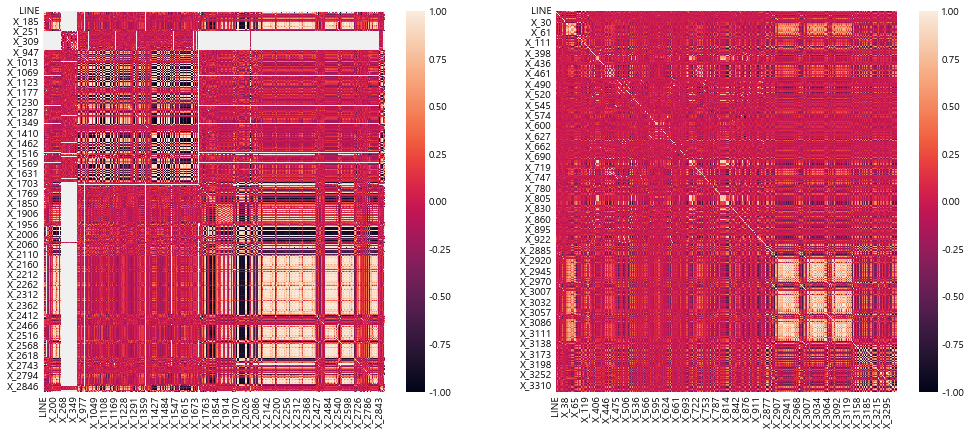

In [45]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots(ncols=2)
sns.heatmap(train_x0.corr(), ax=ax[0])
sns.heatmap(train_x1.corr(), ax=ax[1])
plt.show()

### 결측치 처리
* 결측치가 매우 많고, 변수가 매우 많아서 0으로 처리.
* 다른 impute 방식과 성능 차가 없음

In [46]:
train_x0.fillna(0, inplace=True)
train_x1.fillna(0, inplace=True)
test0.fillna(0, inplace=True)
test1.fillna(0, inplace=True)

### Feature Selection

#### train_x0

In [47]:
estimator = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
selector = RFECV(estimator, step=50, cv=5, min_features_to_select=300, scoring='f1_macro')
selector.fit(train_x0, train_y0)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostClassifier object at 0x0000016C3D8B50D0>,
      min_features_to_select=300, scoring='f1_macro', step=50)

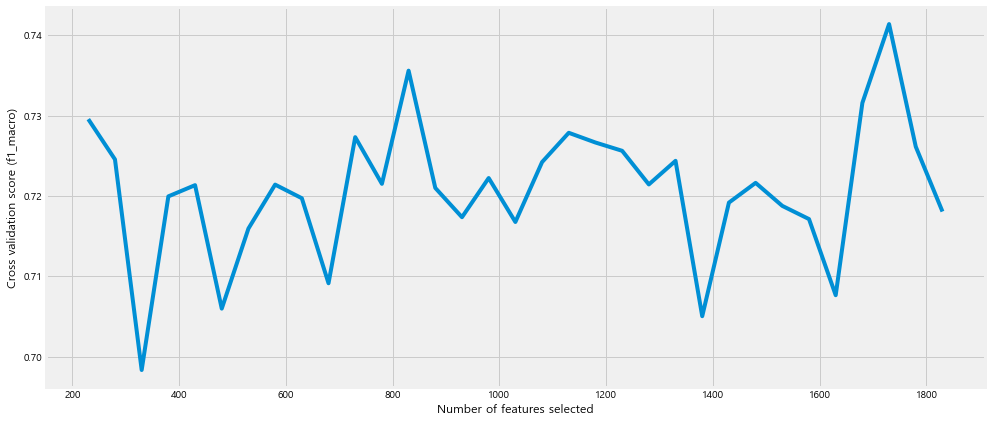

In [48]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_macro)")
plt.plot(
    range(len(train_x0.columns) - len(selector.cv_results_['mean_test_score'])*50, len(train_x0.columns), 50),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [52]:
train_x0 = train_x0[train_x0.columns[selector.support_]]
test0 = test0[train_x0.columns]

In [53]:
train_x0.head()

,X_1,X_2,X_4,X_128,X_129,X_130,X_131,X_132,X_133,X_134,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,20153.0,24984.0,0.21,0.22,0.21,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
21,0.0,0.0,0.0,18031.0,18031.0,0.0,0.0,0.19,0.20,0.19,...,57.74,52.51,54.45,57.99,63.16,1.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,8164.0,8164.0,0.0,0.0,0.19,0.20,0.19,...,56.38,57.10,51.49,56.08,64.40,1.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,17014.0,21844.0,0.20,0.22,0.20,...,50.45,50.29,57.54,52.59,62.37,0.0,0.0,0.0,0.0,0.0


In [55]:
estimator = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
selector = RFECV(estimator, step=50, cv=5, min_features_to_select=50, scoring='f1_macro')
selector.fit(train_x1, train_y1)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostClassifier object at 0x0000016C3D7BDCD0>,
      min_features_to_select=50, scoring='f1_macro', step=50)

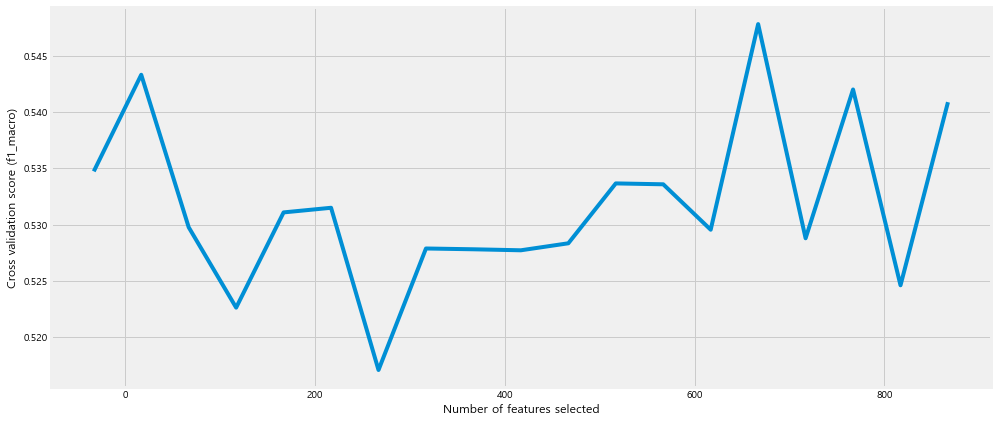

In [56]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1_macro)")
plt.plot(
    range(len(train_x1.columns) - len(selector.cv_results_['mean_test_score'])*50, len(train_x1.columns), 50),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [57]:
train_x1 = train_x1[train_x1.columns[selector.support_]]
test1 = test1[train_x1.columns]

In [58]:
train_x1.head()

,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,X_12,X_13,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,2.0,95.0,45.0,10.0,45.0,10.0,31.0,483.4,489.0,477.8,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189000,0.000006
1,2.0,96.0,45.0,10.0,53.0,10.0,52.0,519.3,526.5,510.4,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185000,0.000029
2,2.0,95.0,45.0,10.0,60.0,10.0,52.0,502.5,510.1,490.7,...,0.000007,0.000003,0.189552,0.000032,0.000689,0.000039,0.000003,0.000003,0.187667,0.000030
3,2.0,87.0,45.0,10.0,53.0,10.0,52.0,478.9,483.4,472.9,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188000,0.000031
4,2.0,95.0,45.0,10.0,51.0,10.0,52.0,508.4,516.3,496.1,...,0.000007,0.000003,0.190205,0.000031,0.000669,0.000039,0.000003,0.000003,0.186667,0.000029


#### Y_Quality

In [59]:
train_yq0 = train.iloc[train_x0.index]['Y_Quality']
train_yq1 = train.iloc[train_x1.index]['Y_Quality']

### reset index

In [61]:
train_x0.reset_index(drop=True, inplace=True)
train_x1.reset_index(drop=True, inplace=True)
train_y0.reset_index(drop=True, inplace=True)
train_y1.reset_index(drop=True, inplace=True)
train_yq0.reset_index(drop=True, inplace=True)
train_yq1.reset_index(drop=True, inplace=True)

### 슬라이싱 및 변수 선택 이전의 데이터로 분류했을 경우

In [62]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
rskf_f1 = []
for i, (t_index, v_index) in enumerate(rskf.split(train_x, train_y)):
    trn_x, val_x, trn_y, val_y = train_x.iloc[t_index], train_x.iloc[v_index], train_y.iloc[t_index], train_y.iloc[v_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
    clf.fit(trn_x, trn_y)
    rskf_f1.append(f1_score(clf.predict(val_x), val_y, average='micro'))
print(np.mean(rskf_f1))

0.7689953608046471


### 전처리 후

### Catboost

In [63]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
for n, x, y in (('train_x0', train_x0, train_y0), ('train_x1', train_x1, train_y1)):
    rskf_f1 = []
    for i, (t_index, v_index) in enumerate(rskf.split(x, y)):
        trn_x, val_x, trn_y, val_y = x.iloc[t_index], x.iloc[v_index], y.iloc[t_index], y.iloc[v_index]

        clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
        clf.fit(trn_x, trn_y)
        rskf_f1.append(f1_score(clf.predict(val_x), val_y, average='micro'))
    print(n, ':', np.mean(rskf_f1))

train_x0 : 0.7347165400350673
train_x1 : 0.7941830624465356


In [64]:
(0.7347165400350673*len(train_x0) + 0.7941830624465356*len(train_x1)) / (len(train_x0)+len(train_x1))

0.7787385769439104

### Stacking. Final Estimator = OneVsRest

In [65]:
estimators = [('lgbm', lightgbm.LGBMClassifier()),
              ('catb', catboost.CatBoostClassifier(verbose=0, task_type='GPU')),
              ('xgb', xgboost.XGBClassifier()),
              ('lgr', LogisticRegression()),
              ('ef', ExtraTreesClassifier()),
              ]

In [66]:
entire_f1 = []
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
for n, x, y in (('train_x0', train_x0, train_y0), ('train_x1', train_x1, train_y1)):
    rskf_f1 = []
    for i, (t_index, v_index) in enumerate(rskf.split(x, y)):
        trn_x, val_x, trn_y, val_y = x.iloc[t_index], x.iloc[v_index], y.iloc[t_index], y.iloc[v_index]

        clf = StackingClassifier(estimators=estimators, final_estimator=OneVsRestClassifier(LogisticRegression()), cv=6, stack_method='predict_proba')
        clf.fit(trn_x, trn_y)
        rskf_f1.append(f1_score(clf.predict(val_x), val_y, average='micro'))
    print(n, ':', np.mean(rskf_f1))
    entire_f1.append(rskf_f1)
print(f'전체 평균 : {np.mean(entire_f1)}')

train_x0 : 0.7621274108708358
train_x1 : 0.8078877958368975
전체 평균 : 0.7850076033538668


### Chain
* Y_Quality (regressor)를 예측하고, Y_Class (classification) 분류 과정에 활용한다.

In [4]:
r_estimators = [('lgbm', lightgbm.LGBMRegressor()),
              ('catb', catboost.CatBoostRegressor(verbose=0, task_type='GPU')),
              ('xgb', xgboost.XGBRegressor()),
              ('lr', LinearRegression()),
              ('ef', ExtraTreesRegressor()),
              ]
c_estimators = [('lgbm', lightgbm.LGBMClassifier()),
              ('catb', catboost.CatBoostClassifier(verbose=0, task_type='GPU')),
              ('xgb', xgboost.XGBClassifier()),
              ('lgr', LogisticRegression()),
              ('ef', ExtraTreesClassifier()),
              ]

In [5]:
entire_f1 = []
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
for n, x, y, yq in (('train_x0', train_x0, train_y0, train_yq0), ('train_x1', train_x1, train_y1, train_yq1)):
    rskf_f1 = []
    for i, (t_index, v_index) in enumerate(rskf.split(x, y)):
        trn_x, val_x, trn_y, val_y, trn_yq, val_yq = x.iloc[t_index], x.iloc[v_index], y.iloc[t_index], y.iloc[v_index], yq.iloc[t_index], yq.iloc[v_index]
        
        # Y_Quality
        clf = StackingRegressor(estimators=r_estimators, final_estimator=LinearRegression(), cv=6)
        clf.fit(trn_x, trn_yq)
        val_x['Y_Quality'] = clf.predict(val_x)
        
        # Y_Class
        trn_x['Y_Quality'] = trn_yq
        clf = StackingClassifier(estimators=c_estimators, final_estimator=OneVsRestClassifier(LogisticRegression()), cv=6, stack_method='predict_proba')
        clf.fit(trn_x, trn_y)
        rskf_f1.append(f1_score(clf.predict(val_x), val_y, average='micro'))
    print(n, ':', np.mean(rskf_f1))
    entire_f1.append(rskf_f1)
print(f'전체 평균 : {np.mean(entire_f1)}')

train_x0 : 0.7617475160724723
train_x1 : 0.8174151696606786
전체 평균 : 0.7895813428665754


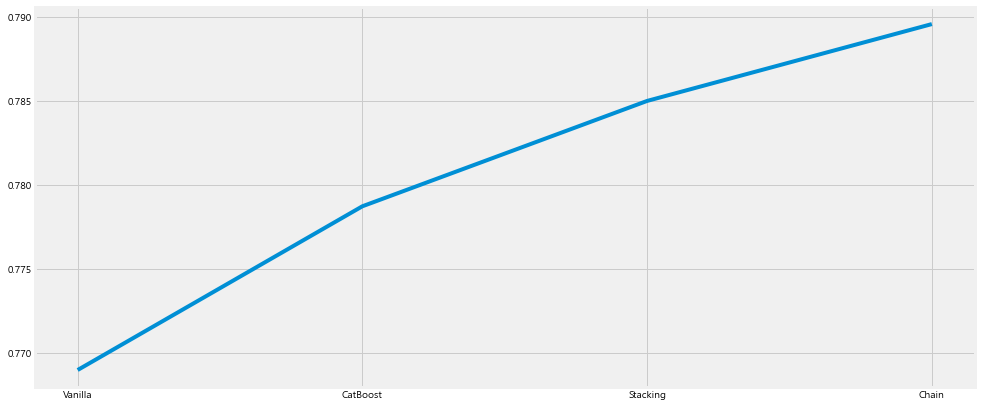

In [10]:
rcParams['figure.figsize'] = 15, 7
sns.lineplot(x=['Vanilla', 'CatBoost', 'Stacking', 'Chain'], y=[0.7689953608046471, 0.7787385769439104, 0.7850076033538668, 0.7895813428665754])
plt.show()